# Inundation Risk Modelling With HAND Model

#### This notebook demonstrates flood risk assessment using the Height Above Nearest Drainage (HAND) model. By using Digital Elevation Models (DEMs) and calculating the vertical distance of terrain points from the drainage network, the HAND model helps classify areas based on their flood risk potential. The workflow is implemented with Python libraries such as rasterio, numpy, richdem, and matplotlib. The goal is to classify regions into low, medium, and high flood risk categories. The notebook covers data preparation, HAND calculation, and flood risk classification with clear, reproducible steps.

## Environment Preparation
#### First, we need to import the necessary packages and libraries:
1. Numpy - array manipulation;
2. Whiteboxtools - Geospatial analysis and manipulation;
3. GDAL - Geospatial data manipulation;
4. RichDEM - DEM and hydrological analysis tools;
5. Matplotlib - Data Visualization.

In [1]:
# import packages
import numpy as np
from WBT.whitebox_tools import WhiteboxTools
from osgeo import gdal
import richdem as rd
import matplotlib.pyplot as plt

## Data Loading and metadata retrieving
#### Next, we'll load the elevation data (DEM) file using gdal and get the necessary metadata

In [2]:
# load MDE file using gdal
dem_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/S06W039_FABDEM_V1-2.tif'
dem_dataset = gdal.Open(dem_path)
dem_band = dem_dataset.GetRasterBand(1)
dem_array = dem_band.ReadAsArray()

# Get necessary metadata for saving later
geotransform = dem_dataset.GetGeoTransform()
projection = dem_dataset.GetProjection()
nodata_value = dem_band.GetNoDataValue()


## Visualize the DEM file with RichDEM rdShow function

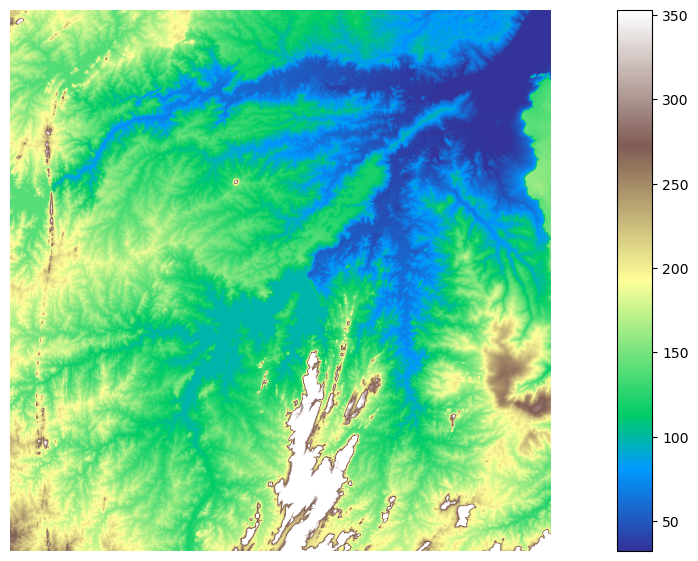

In [3]:
# plot the DEM file with the rdShow function
dem_rd = rd.rdarray(dem_array, no_data=nodata_value)
dem_fig = rd.rdShow(dem_rd, ignore_colours=[0], axes=False, cmap='terrain', figsize=(8,6))

## Preprocessing: Prepare the DEM by filling depressions using richdem or another method to ensure accurate hydrological modeling
#### We'll use the richdem FillDepressions functions to fill possible depressions on the DEM file

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 1.76317 s======================] (100% - 0.0s - 1 threads)
m Cells processed = 12960000
m Cells in pits = 1075152


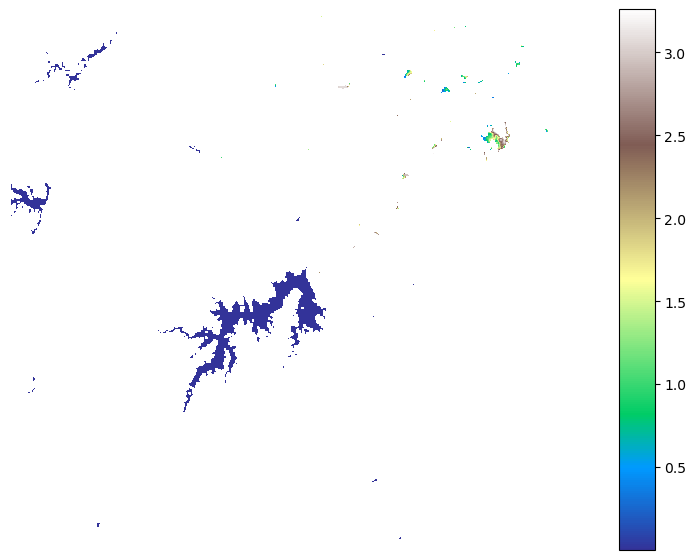

In [4]:
dem_filled = rd.FillDepressions(dem_rd, epsilon=True, in_place=False)

# check the areas that changed
dem_diff = dem_filled - dem_rd
diff_fig = rd.rdShow(dem_diff, ignore_colours=[0], axes=False, cmap='terrain', figsize=(8,6))

### Saving intermediary products

In [5]:
# saving the filled DEM
output_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/dem_filled.tif'

driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(output_path, dem_dataset.RasterXSize, dem_dataset.RasterYSize, 1, gdal.GDT_Float32)

# Set the geotransform and projection from the original DEM
out_ds.SetGeoTransform(geotransform)
out_ds.SetProjection(projection)

# Write the filled DEM data to the output file
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(np.array(dem_filled))

# Set the NoData value if present
if nodata_value is not None:
    out_band.SetNoDataValue(nodata_value)

# Flush data to disk and close the datasets
out_band.FlushCache()
out_ds = None
ds = None

print(f"Filled DEM saved to {output_path}")

Filled DEM saved to /Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/dem_filled.tif


## Processing
### The processing phase comprises 4 steps:
* Step 1: Calculating Flow Directions<br>Calculate flow directions using a D8 or similar flow direction algorithm. This determines where water would flow from each pixel.
* Step 2: Calculating Flow Accumulation<br>Use the flow direction data to compute flow accumulation. This will identify areas where water tends to accumulate, which helps in understanding drainage patterns.
<br>
* Step 3: Extracting Stream Network<br>Extract the stream network based on the flow accumulation. Streams are usually defined by a threshold in flow accumulation, where pixels exceeding the threshold are considered part of the drainage network.
<br>
* Step 4: Calculating HAND (Height Above Nearest Drainage)<br>Calculate the Height Above Nearest Drainage (HAND) using whiteboxtools. The HAND calculation determines the vertical height of each cell above the nearest stream in the network.

## Step 1: Calculating Flow Directions
#### Calculates the direction of flow from each cell to its downslope neighbor or neighbors using the D8 method.

![alt text](image.png) <br>
    (Source: ESRI)

#### The output of the Flow Direction tool run with the D8 flow direction type is an integer raster whose values range from 1 to 255.

In [6]:
# Initialize WhiteboxTools
wbt = WhiteboxTools()
wbt.work_dir = "/Users/marcussena/Documents/articles_notebooks/flood_simulation"

In [7]:
# Calculate flow directions
filled_dem_path = output_path
flow_direction_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_dir.tif'
wbt.d8_pointer(filled_dem_path, flow_direction_path, esri_pntr=True)

./whitebox_tools --run="D8Pointer" --wd="/Users/marcussena/Documents/articles_notebooks/flood_simulation" --dem='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/dem_filled.tif' --output='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_dir.tif' --esri_pntr

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 3

0

## Step 2: Calculating Flow Accumulation

#### Flow Accumulation calculates accumulated flow as the accumulated weight of all cells flowing into each downslope cell in the output raster. If no weight raster is provided, a weight of 1 is applied to each cell, and the value of cells in the output raster is the number of cells that flow into each cell.
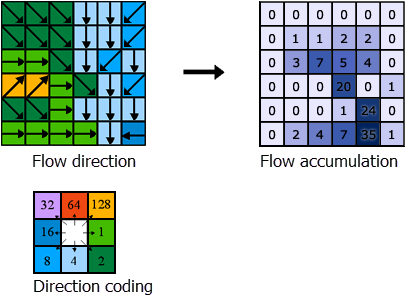
(Source: ESRI)

In [8]:
# Calculate flow accumulation
flow_accumulation_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_accum.tif'
wbt.d8_flow_accumulation(flow_direction_path, flow_accumulation_path, pntr=True)

./whitebox_tools --run="D8FlowAccumulation" --wd="/Users/marcussena/Documents/articles_notebooks/flood_simulation" --input='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_dir.tif' --output='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_accum.tif' --out_type=cells --pntr

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow directions: 17%
Flow directions: 18%
Flow directions: 19%
Flow directions: 20%
Flow directions: 21%
Flow direct

0

## Step 3: Extracting Stream Network

In [32]:
# Set threshhold to identify stream network
threshold = 12.0
streams_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_streams.tif'
wbt.extract_streams(flow_accumulation_path, streams_path, threshold)

./whitebox_tools --run="ExtractStreams" --wd="/Users/marcussena/Documents/articles_notebooks/flood_simulation" --flow_accum='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_flow_accum.tif' --output='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_streams.tif' --threshold='12.0'

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress

0

## Step 4: Calculating HAND (Height Above Nearest Drainage)

In [33]:
# Calculate HAND from streams network file using the WhiteBoxTools elevation_above_stream function
hand_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_hand.tif'
wbt.elevation_above_stream(filled_dem_path, streams_path, hand_path)

./whitebox_tools --run="ElevationAboveStream" --wd="/Users/marcussena/Documents/articles_notebooks/flood_simulation" --dem='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/dem_filled.tif' --streams='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_streams.tif' --output='/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_dem_hand.tif'

***********************************
* Welcome to ElevationAboveStream *
* Powered by WhiteboxTools        *
* www.whiteboxgeo.com             *
***********************************
Reading DEM data...
Reading streams data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow dire

0

## Classifying Flood Risk Using HAND
#### Load the HAND raster file and classify regions into different risk levels based on thresholds.

In [34]:
# classify zones by risk of inundation
hand_dataset = gdal.Open(hand_path)
hand_array = hand_dataset.ReadAsArray()
geotransform = hand_dataset.GetGeoTransform()
projection = hand_dataset.GetProjection()

In [35]:
# Set the intervals for inundation risk
very_high_risk = (hand_array >= 0) & (hand_array <= 1)
high_risk = (hand_array > 1) & (hand_array <= 2)
medium_risk = (hand_array > 2) & (hand_array <= 6)
low_risk = (hand_array > 6) & (hand_array <= 10)
very_low_risk = (hand_array > 10)

# Initialize an array with zeros (or no data)
risk_classification = np.zeros_like(hand_array, dtype=np.uint8)

# Assign class values based on risk intervals
risk_classification[very_high_risk] = 5    # Very High Risk
risk_classification[high_risk] = 4    # High Risk
risk_classification[medium_risk] = 3  # Medium Risk
risk_classification[low_risk] = 2     # Low Risk
risk_classification[very_low_risk] = 1 # Very Low Risk

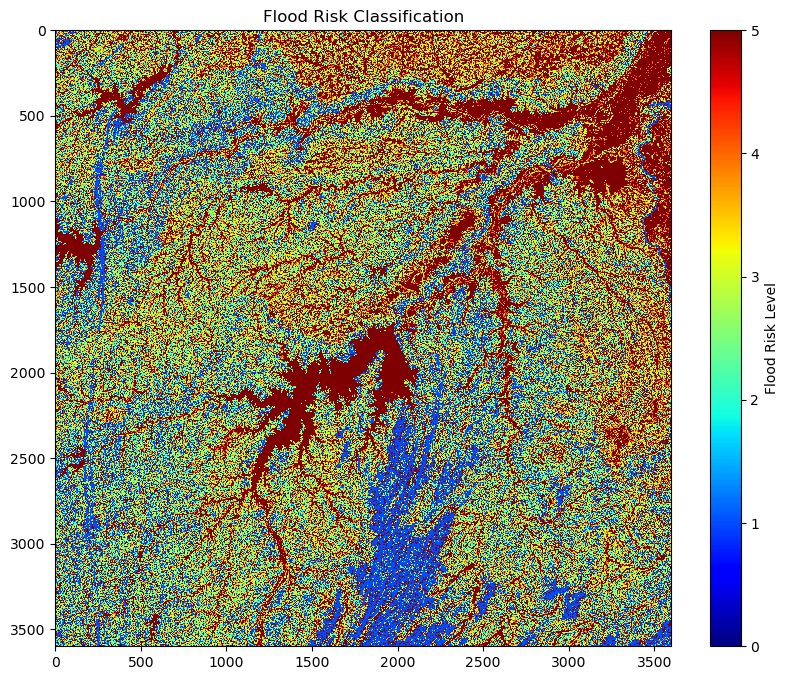

In [36]:
# Use matplotlib to see the results
plt.figure(figsize=(10, 8))
plt.imshow(risk_classification, cmap='jet', interpolation='none')
plt.colorbar(label="Flood Risk Level")
plt.title("Flood Risk Classification")
plt.show()

## Save the classified file as GEOTIFF
#### It is helpful to visualize in a GIS software such as QGIS

In [37]:
# saving the classified HAND file
classified_risk_path = '/Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_classified_hand.tif'

# Create the GEOTIFF driver for the classified file
driver = gdal.GetDriverByName("GTiff")
out_dataset = driver.Create(
    classified_risk_path,
    hand_dataset.RasterXSize,
    hand_dataset.RasterYSize,
    1,
    gdal.GDT_Byte
)

# Set the geotransform and projection from the original DEM
out_dataset.SetGeoTransform(geotransform)
out_dataset.SetProjection(projection)

# Write the filled DEM data to the output file
out_band = out_dataset.GetRasterBand(1)
out_band.WriteArray(risk_classification)
out_band.SetNoDataValue(0)  # Set the NoData value if present

# Flush data to disk and close the datasets
out_dataset.FlushCache()
out_dataset = None

print(f"Classified HAND file saved to {classified_risk_path}")

Classified HAND file saved to /Users/marcussena/Documents/articles_notebooks/flood_simulation/workflow/rec_classified_hand.tif


# Conclusion
### The flood risk classification map generated in this workflow allows for the clear identification of areas with varying flood risk levels based on the HAND model. The visualization displays three categories of risk: high, medium, and low, determined by the vertical distance of each terrain point from the nearest drainage network.

- High-risk areas (colored red in the visualization) represent regions closest to drainage channels and with the lowest HAND values, indicating the highest potential for flooding.
- Medium-risk areas (colored yellow) are slightly higher above the drainage network and may experience flooding during more severe events.
- Low-risk areas (colored blue) are the highest above the drainage network and less likely to flood, even in extreme rainfall events.
- By analyzing this map, decision-makers can prioritize flood prevention and mitigation strategies for the most vulnerable areas. The classification helps identify zones where infrastructure or land use may require additional flood defenses, planning measures, or further analysis using more detailed hydrological models.

# References
1. Esri. How Flow Direction works. ArcGIS Pro Tool Reference. Retrieved September 14, 2024, from https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-flow-direction-works.htm

2. Esri. How Fill works. ArcGIS Pro Tool Reference. Retrieved September 14, 2024, from https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-fill-works.htm

3. Esri. How Flow Accumulation works. ArcGIS Pro Tool Reference. Retrieved September 14, 2024, from https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-flow-accumulation-works.htm

4. Johnson, J. M., Munasinghe, D., Eyelade, D., & Cohen, S. (2019). An integrated evaluation of the National Water Model (NWM)–Height Above Nearest Drainage (HAND) flood mapping methodology. University of California, Santa Barbara and University of Alabama.